# GetOgb1Data
This notebook loads the OGB-1 dataset from Baden2016 (Nature) and extracts data relevant to RGC cluster assignment of GCaMP6f data
Duration: foopsi 7.8 Hz: 4220 s = 70 min

# TODO:

- save cells rather than group means?
 - if so, just save it as additional var when getting the group averages

- code optimization
 - save data in one struct rather than sep vars
  - could save data in pd df, and save this as hdf5
  - or save as dict
   - this would make manipulations across variables automatically consistent, e.g. reducing df would be one operation rather than several
   - also makes loops easier
 - make stimulus loading flexible wrt stimulus, i.e. function that loops through stimuli
  - i.e. every time you see Chirp and Bar, do it in one go:
   - loading averages, times, reducing data to RGCs only
    - use p['stim']

# Qs
- why is bar trace in fps=8?
- Why is metadata infotext not available on datadryad anymore?

# Pre-info

- data from Baden2016, Nature
- chirp_avg: median of all repeats, scaled to max(abs(x))=1
- use group_idx for grouping avg respose (remaining clusters after SNR-criterion; <> cluster_idx contains all clusters)
 - group_idx: RGCs: 1-28, uncertain RGCs: 29-32, other: 33-46
 - clu_idx: RGCs: 1-39, uncertain RGCs: 40-49, other: 50-76

# Setup

In [1]:
# Library setup
# Data libs
import sys
import os # directory lib
import h5py # HDF5 lib
import numpy as np # linear alg lib
import scipy.io as sio
from scipy import interpolate
import time

# Plotting libs
import matplotlib.pyplot as plt # plotting lib
import matplotlib.gridspec as gridspec
import seaborn as sns # nice plotting lib
from pylab import rcParams

# Misc libs
import warnings
from __future__ import print_function

# Custom modules
sys.path.append('../utils/') # Import path to utility functions
import postProc as pop # Import PostProcessing module (functions: normalization, interpolation, QI etc.)

In [2]:
# sys.path.append('/Volumes/ybauer/code/py-oopsi-master')
# import oopsi

In [3]:
# Reload module
import importlib
importlib.reload(pop)

<module 'postProc' from '../utils/postProc.py'>

In [4]:
# matplotlib inline is a jupyter requirement for plotting
%matplotlib inline

In [5]:
# Parameter setup
p = {}
p.update({
        # Choose if analysing groups or clusters
        'groupVClu': 'group', # OPTIONS: 'group', 'clu'
        
        # IO pars
        'loadDir': "../../data/2P/raw/",#'/Volumes/busse_lab/users/yannik/data/2P/BadenEtAl_RGCs_2016_v1.mat', # load directory
        'loadFid': "BadenEtAl_RGCs_2016_v1.mat",
        'saveDir': "../../data/2P/proc/",#'/Volumes/busse_lab/users/yannik/data/2P/', # save directory        
        'saveFid': 'BadenEtAl_RGCs_2016_ogb1', # file ID for group ana        
        'fileFmt': '.mat', # fileFormat

        # RGC-cells (see pre-info)
        
        # Set stimuli of interest & var names for dataframe accordingly
        'stim': ["chirp", "bar"], # stimulus name
        
        # Cell type pars
        'rgcRangeGroup': [1, 32], # Set range of RGC cell groups (see pre-info)
        'rgcRangeClu': [1, 49], # Set range of RGC cell clusters (see pre-info)
        
        # Normalization pars
        'doNorm': True, # Set if to do normalization or not
        'normMode': 'medMax', # see normalization function
        
        # Resampling pars
        'doResample': False,
        'newSRate': 40, # Desired sampling rate in Hz (old: 7.825)
        
        # Deconvolution pars
        'deconvMethod': 'ogb1Kern', # OPTIONS: 'ogb1Kern', 'foopsi'
        })


# Build save file name
p['saveFid'] = p['saveFid']+"_"+p['groupVClu']+"_"+p['deconvMethod']
if p['doResample']:
    p['saveFid'] = p['saveFid']+"_"+str(p['newSRate'])+"Hz"+p['fileFmt']
else:
    p['saveFid'] = p['saveFid']+"_"+"7.8Hz"+p['fileFmt']

p

{'deconvMethod': 'ogb1Kern',
 'doNorm': True,
 'doResample': False,
 'fileFmt': '.mat',
 'groupVClu': 'group',
 'loadDir': '../../data/2P/raw/',
 'loadFid': 'BadenEtAl_RGCs_2016_v1.mat',
 'newSRate': 40,
 'normMode': 'medMax',
 'rgcRangeClu': [1, 49],
 'rgcRangeGroup': [1, 32],
 'saveDir': '../../data/2P/proc/',
 'saveFid': 'BadenEtAl_RGCs_2016_ogb1_group_ogb1Kern_7.8Hz.mat',
 'stim': ['chirp', 'bar']}

# Load

In [6]:
# Load .mat file
ogb1 = sio.loadmat(p['loadDir']+p['loadFid'])
# ogb1.shape

In [7]:
sio.whosmat(p['loadDir']+p['loadFid'])

[('ans', (1, 1), 'double'),
 ('noise_time', (11210, 1), 'struct'),
 ('noise_trace', (1750, 11210), 'double'),
 ('noise_stim', (20, 15, 1750, 171), 'double'),
 ('cluster_idx', (11210, 1), 'double'),
 ('group_idx', (11210, 1), 'double'),
 ('c2g', (1, 75), 'double'),
 ('sel_idx', (11210, 1), 'logical'),
 ('cell_dsi', (11210, 1), 'double'),
 ('cell_dp', (11210, 1), 'double'),
 ('cell_osi', (11210, 1), 'double'),
 ('cell_op', (11210, 1), 'double'),
 ('cell_area', (11210, 1), 'double'),
 ('cell_volume', (11210, 1), 'double'),
 ('cell_id', (11210, 7), 'double'),
 ('cell_oo_idx', (11210, 1), 'double'),
 ('cell_ff_idx', (11210, 1), 'double'),
 ('chirp_avg', (249, 11210), 'double'),
 ('chirp_byrepeat', (249, 5, 11210), 'double'),
 ('chirp_time', (1, 249), 'double'),
 ('chirp_stim', (31988, 1), 'double'),
 ('chirp_stim_time', (1, 31988), 'double'),
 ('chirp_qi', (11210, 1), 'double'),
 ('chirp_scaling', (11210, 1), 'double'),
 ('bar_byrepeat', (32, 8, 3, 11210), 'double'),
 ('bar_tc', (32, 11210)

## Get Ca++ intensity traces of ROIs stimuli: trial averages

In [8]:
# Chirp stim
chirpAvg = ogb1['chirp_avg']
print(chirpAvg.shape)

# DS stim
barAvg = ogb1['bar_tc']
print(barAvg.shape)

(249, 11210)
(32, 11210)


## Get stimulus times

In [9]:
# Chirp
chirpTime = ogb1['chirp_time'][0]
print(chirpTime.shape)
print('chirpTime:', chirpTime[0], chirpTime[-1])
chirpDur = chirpTime[-1] - chirpTime[0]
print('chirpDur:', chirpDur)
p['chirpFps'] = chirpTime.shape[0] / chirpDur
print('chirpFps:', p['chirpFps'])

chirpStimTime = ogb1['chirp_stim_time'][0]
print(chirpStimTime[-1])

# Bar
barTime = ogb1['bar_time'][0]
print(barTime.shape)
print('barTime:', barTime[0], barTime[-1])
barDur = barTime[-1] - barTime[0]
print('barDur:', barDur)
p['barFps'] = barTime.shape[0] / barDur
print('barFps:', p['barFps'])

(249,)
chirpTime: 0.0641542168675 31.8846457831
chirpDur: 31.8204915663
chirpFps: 7.82514624205
32.0
(32,)
barTime: 0.0 4.0
barDur: 4.0
barFps: 8.0


## Get group/cluster indices of ROIs

In [10]:
# RGCs: 1-28, uncertain: 29-32, other: > 32

# Get groups or clusters depending on parameter setting
if p['groupVClu'] == 'clu':
    groupIdx = ogb1['cluster_idx']
elif p['groupVClu'] == 'group':
    groupIdx = ogb1['group_idx']

print('nCells:', groupIdx.shape)
print('example groupIdx:\n', groupIdx[0:10]) # print example
print('unique groupIdx:\n', np.unique(groupIdx)) # confirm that groupIdx contains indices as specified in help text

nCells: (11210, 1)
example groupIdx:
 [[-1]
 [12]
 [-1]
 [12]
 [35]
 [31]
 [-1]
 [17]
 [46]
 [14]]
unique groupIdx:
 [-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


## Get quality indices (QI) for cells - see Baden2016 or getGcamp6Data for details

In [11]:
# Chirp
chirpQi = ogb1['chirp_qi']
print(chirpQi.shape)
print(np.min(chirpQi))
print(np.max(chirpQi))
print(np.sort(chirpQi, axis=0)[0:10,0])

# Bar
barQi = ogb1['bar_qi']
print(barQi.shape)
print(barQi[0:10,0])
print(np.min(barQi))
print(np.max(barQi))
print(np.sort(barQi, axis=0)[0:10,0])

(11210, 1)
0.0983015969396
1.0
[ 0.0983016  0.120863   0.128501   0.140333   0.153041   0.158132   0.158632
  0.164066   0.164329   0.166061 ]
(11210, 1)
[ 0.45854601  0.92307502  0.49250901  0.90350097  0.86311299  0.86117202
  0.34725001  0.64195597  0.867962    0.84226602]
0.265197008848
0.989113986492
[ 0.26519701  0.271816    0.302178    0.323476    0.32687101  0.330311
  0.331785    0.33274299  0.33759701  0.33906299]


## Get cell direction selectivity
cell direction selectivity will be used as step 1 in pre-clustering gcmap6 cells into DS or non-DS

In [12]:
# Get cell Direction selectivity index (DSI)
cellDsi = ogb1['cell_dsi']
print('example cell DSIs:\n', cellDsi[0:10])
# Get cell DSI p-value
cellDsiPval = ogb1['cell_dp']
print('examples cell DSI p-vals:\n', cellDsiPval[0:10])

# Make logical index of DSI-cells := DSI-Pval <= 0.05
cellDsiBool = np.zeros((len(cellDsi),1), dtype=int)
for idx, val in enumerate(cellDsiPval):
    if val <= 0.05:
        cellDsiBool[idx] = 1

print('examples: DS or not:\n', cellDsiBool[0:10])

example cell DSIs:
 [[ 0.28003699]
 [ 0.40977299]
 [ 0.31827399]
 [ 0.48289701]
 [ 0.25057   ]
 [ 0.36130801]
 [ 0.109525  ]
 [ 0.34162799]
 [ 0.336631  ]
 [ 0.51661801]]
examples cell DSI p-vals:
 [[ 0.62599999]
 [ 0.004     ]
 [ 0.16      ]
 [ 0.        ]
 [ 0.204     ]
 [ 0.002     ]
 [ 0.66100001]
 [ 0.18000001]
 [ 0.008     ]
 [ 0.093     ]]
examples: DS or not:
 [[0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]]


## Get cell soma area
Soma size (area) of groups will be used as step 2 (after DS-pre-clustering) in pre-clustering cells into large vs small

In [13]:
cellArea = ogb1['cell_area']
print(cellArea)

[[ 24.22489929]
 [ 43.06639862]
 [ 34.99150085]
 ..., 
 [ 40.3748    ]
 [ 64.5996    ]
 [ 51.1414    ]]


# Process data

## Reduce data to RGC groups/clusters only

In [14]:
### Get average traces of RGCs only
if p['groupVClu'] == 'group':
    rgcRange = p['rgcRangeGroup']
elif p['groupVClu'] == 'clu':
    rgcRange = p['rgcRangeClu']

# Chirp
# chirpAvgRgc = chirpAvg[:, ((groupIdx>=rgcRange[0]) & (groupIdx<=rgcRange[1]))] # logical idxg wrong bhv?? >< bec log is 2D-array
chirpAvgRgc = chirpAvg[:, np.where((groupIdx>=rgcRange[0]) & (groupIdx<=rgcRange[1]))[0]] # use np.where and idx [0] of the output tuple

print(chirpAvgRgc.shape)
# print(chirpAvgRgc[:,0:2]) # print example

# Bar
barAvgRgc = barAvg[:, np.where((groupIdx>=rgcRange[0]) & (groupIdx<=rgcRange[1]))[0]] # use np.where and idx [0] of the output tuple
print(barAvgRgc.shape)

(249, 5024)
(32, 5024)


QQ: does this ensure that the indices are in the same order as in chirpAvgRgc?
- seems so by vis inspection

In [15]:
### Get groupIdx of RGCs only
groupIdxRgc = groupIdx[(groupIdx>=rgcRange[0]) & (groupIdx<=rgcRange[1])]
print(groupIdxRgc.shape)
print(np.unique(groupIdxRgc))
print(groupIdxRgc[0:20]) # print example

(5024,)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32]
[12 12 31 17 14 16 20 16 16 30 12 14 14 10 22 18 31  6 17 16]


In [16]:
### Get QIs of RGCs only
# not used further, as group means taken > maybe take group mean QI?

# Chirp
chirpQiRgc = chirpQi[(groupIdx>=rgcRange[0]) & (groupIdx<=rgcRange[1])]
print(chirpQiRgc.shape)

# Bar
barQiRgc = barQi[(groupIdx>=rgcRange[0]) & (groupIdx<=rgcRange[1])]
print(barQiRgc.shape)

(5024,)
(5024,)


In [17]:
### Get cellDsiBool of RGCs only
cellDsiBool = cellDsiBool[(groupIdx>=rgcRange[0]) & (groupIdx<=rgcRange[1])]
print(cellDsiBool.shape)

(5024,)


## Resample OGB-1 data

In [18]:
if p['doResample']:
    print('Resampling to %.3f Hz' %p['newSRate'])
    # Chirp
    p['chirpFps'] = p['newSRate']
    print(chirpAvgRgc.shape)
    chirpAvgRgc = pop.interpNewSRate(chirpAvgRgc, p['chirpFps'], chirpDur)
    print(chirpAvgRgc.shape)

    # Bar
    p['barFps'] = p['newSRate']
    print(barAvgRgc.shape)
    barAvgRgc = pop.interpNewSRate(barAvgRgc, p['barFps'], barDur)
    print(barAvgRgc.shape)

In [19]:
# Adjust stimulus times to resampled traces
chirpTime = np.linspace(chirpTime[0], chirpTime[-1], chirpAvgRgc.shape[0])
print(chirpTime.shape)

barTime = np.linspace(barTime[0], barTime[-1], barAvgRgc.shape[0])
print(barTime.shape)

(249,)
(32,)


## Get avg traces and deconvolved traces of each RGC group for each stimulus
- NOTE: mean traces are normalizeed like in Baden2016 <> deconvolved traces are range-normalized (due to non-negativity of firing rates) 
- this will output groups in the same order as Baden2016
- TODO: 
 - make flexible wrt stim

In [20]:
# %%time
# Time cell execution
start = time.time()

## Chirp
# Initialize 2D array (nec in python; alternatives in testing section below)
tPoints = chirpAvgRgc.shape[0]
nGroups = np.unique(groupIdxRgc).shape[0]
chirpAvgRgcGroupMean = np.zeros((tPoints, nGroups))
chirpAvgRgcGroupMed = np.zeros((tPoints, nGroups))
chirpAvgRgcGroupSd = np.zeros((tPoints, nGroups))
chirpAvgRgcGroupDeconvMean = np.zeros((tPoints, nGroups))
chirpAvgRgcGroupDeconvSd = np.zeros((tPoints, nGroups))
chirpAvgRgcGroupMeanDeconv = np.zeros((tPoints, nGroups))
chirpN = np.zeros((1, nGroups), dtype=int)

# Process each RGC group
for idx, iGroup in enumerate(np.unique(groupIdxRgc)):
    
    print('chirp group %i' %iGroup)
    
    # Get mean (normalize for mean)
    chirpAvgRgc[:, groupIdxRgc==iGroup] = pop.normalize(chirpAvgRgc[:, groupIdxRgc==iGroup], mode='meanMax')
    chirpAvgRgcGroupMean[:, idx] = np.mean(chirpAvgRgc[:, groupIdxRgc==iGroup], axis=1)
    chirpAvgRgcGroupSd[:, idx] = np.std(chirpAvgRgc[:, groupIdxRgc==iGroup], axis=1)

    # Get median (normalize for median)
    chirpAvgRgc[:, groupIdxRgc==iGroup] = pop.normalize(chirpAvgRgc[:, groupIdxRgc==iGroup], mode='medMax')
    chirpAvgRgcGroupMed[:, idx] = np.median(chirpAvgRgc[:, groupIdxRgc==iGroup], axis=1)
    
    chirpN[0, idx] = chirpAvgRgc[:, groupIdxRgc==iGroup].shape[1]
    
    # NOTE: for range-norm, don't pre-norm single traces, get mean and sd, and scale sd by max(mean), 
    #   then norm single traces
#     chirpAvgRgcGroupSd[:, idx] /= max(chirpAvgRgcGroupMean[:, idx])
#     chirpAvgRgcGroupMean[:, idx] = pop.normalize(chirpAvgRgcGroupMean[:, idx], mode='r')
#     chirpAvgRgcGroupMed[:, idx] = pop.normalize(chirpAvgRgcGroupMed[:, idx], mode='r')
    
    ## Deconvolve    
    # mean(Deconv single traces): deconvolve single traces, then take the mean
    traces = chirpAvgRgc[:, groupIdxRgc==iGroup]
    d, traceSm = pop.deconv(traces, fps=p['chirpFps'], method=p['deconvMethod'], smooth=True, norm=True)
    d = pop.normalize(d, mode='meanR') # Normalize 
    chirpAvgRgcGroupDeconvMean[:,idx] = np.mean(d, axis=1)
    chirpAvgRgcGroupDeconvSd[:,idx] = np.std(d, axis=1)
    
    # Deconv(group averages): take the mean trace, then deconvolve it
    # NOTE: this method does not produce an SD
    trace = chirpAvgRgcGroupMean[:, idx]
    d, traceSm = pop.deconv(trace, fps=p['chirpFps'], method=p['deconvMethod'], smooth=True, norm=True)
    chirpAvgRgcGroupMeanDeconv[:,idx] = pop.normalize(d, mode='r') # Normalize

print(chirpAvgRgcGroupMean.shape)
# print(chirpAvgRgcGroupMean[:,[0,1,2]]) # print example

## Bar
# Initialize 2D array (nec in python; alternatives in testing section below)
tPoints = barAvgRgc.shape[0]
nGroups = np.unique(groupIdxRgc).shape[0]
barAvgRgcGroupMean = np.zeros((tPoints, nGroups))
barAvgRgcGroupMed = np.zeros((tPoints, nGroups))
barAvgRgcGroupSd = np.zeros((tPoints, nGroups))
barAvgRgcGroupDeconvMean = np.zeros((tPoints, nGroups))
barAvgRgcGroupDeconvSd = np.zeros((tPoints, nGroups))
barAvgRgcGroupMeanDeconv = np.zeros((tPoints, nGroups))
barN = np.zeros((1, nGroups), dtype=int)

# Process each RGC group
for idx,iGroup in enumerate(np.unique(groupIdxRgc)):
    
    print('bar group %i' %iGroup)
    
    # Get mean (normalize for mean)
    barAvgRgc[:, groupIdxRgc==iGroup] = pop.normalize(barAvgRgc[:, groupIdxRgc==iGroup], mode='meanMax')
    barAvgRgcGroupMean[:, idx] = np.mean(barAvgRgc[:, groupIdxRgc==iGroup], axis=1)
    barAvgRgcGroupSd[:, idx] = np.std(barAvgRgc[:, groupIdxRgc==iGroup], axis=1)

    # Get median (normalize for median)
    barAvgRgc[:, groupIdxRgc==iGroup] = pop.normalize(barAvgRgc[:, groupIdxRgc==iGroup], mode='medMax')
    barAvgRgcGroupMed[:, idx] = np.median(barAvgRgc[:, groupIdxRgc==iGroup], axis=1)
    
    barN[0, idx] = barAvgRgc[:, groupIdxRgc==iGroup].shape[1]    
    
    ## Deconvolve
    # mean(Deconv single traces)
    traces = barAvgRgc[:, groupIdxRgc==iGroup]
    d, traceSm = pop.deconv(traces, fps=p['barFps'], method=p['deconvMethod'], smooth=True, norm=True)
    d = pop.normalize(d, mode='meanR') # Normalize 
    barAvgRgcGroupDeconvMean[:,idx] = np.mean(d, axis=1)
    barAvgRgcGroupDeconvSd[:,idx] = np.std(d, axis=1)

    barAvgRgcGroupDeconvMean[:,idx] = pop.normalize(np.mean(d, axis=1), mode='r') # Normalize
    
    # Deconv(group averages)
    trace = barAvgRgcGroupMean[:, idx]
    d, traceSm = pop.deconv(trace, fps=p['barFps'], method=p['deconvMethod'], smooth=True, norm=True)
    barAvgRgcGroupMeanDeconv[:,idx] = pop.normalize(d, mode='r') # Normalize
    
print(barAvgRgcGroupMean.shape)
# print(barAvgRgcGroupMean[:,[0,1,2]]) # print example


print('DONE.')
dur = (time.time() - start)
print('Duration: %.2f sec = %.2f min' %(dur, dur/60))

chirp group 1
chirp group 2
chirp group 3
chirp group 4
chirp group 5
chirp group 6
chirp group 7
chirp group 8
chirp group 9
chirp group 10
chirp group 11
chirp group 12
chirp group 13
chirp group 14
chirp group 15
chirp group 16
chirp group 17
chirp group 18
chirp group 19
chirp group 20
chirp group 21
chirp group 22
chirp group 23
chirp group 24
chirp group 25
chirp group 26
chirp group 27
chirp group 28
chirp group 29
chirp group 30
chirp group 31
chirp group 32
(249, 32)
bar group 1
bar group 2
bar group 3
bar group 4
bar group 5
bar group 6
bar group 7
bar group 8
bar group 9
bar group 10
bar group 11
bar group 12
bar group 13
bar group 14
bar group 15
bar group 16
bar group 17
bar group 18
bar group 19
bar group 20
bar group 21
bar group 22
bar group 23
bar group 24
bar group 25
bar group 26
bar group 27
bar group 28
bar group 29
bar group 30
bar group 31
bar group 32
(32, 32)
DONE.
Duration: 2.19 sec = 0.04 min


In [25]:
p['chirpFps']

7.8251462420517992

In [21]:
# Reload module
import importlib
importlib.reload(pop)

<module 'postProc' from '../utils/postProc.py'>

In [22]:
traces = chirpAvgRgc[:, groupIdxRgc==iGroup]
d, traceSm = pop.deconv(traces, fps=p['chirpFps'], method=p['deconvMethod'], smooth=True, norm=True)
d = pop.normalize(d, mode='meanR') # Normalize 
chirpAvgRgcGroupDeconvMean[:,0] = np.mean(d, axis=1)
chirpAvgRgcGroupDeconvSd[:,0] = np.std(d, axis=1)

In [220]:
chirpAvgRgcGroupDeconvMean.shape

(1272, 49)

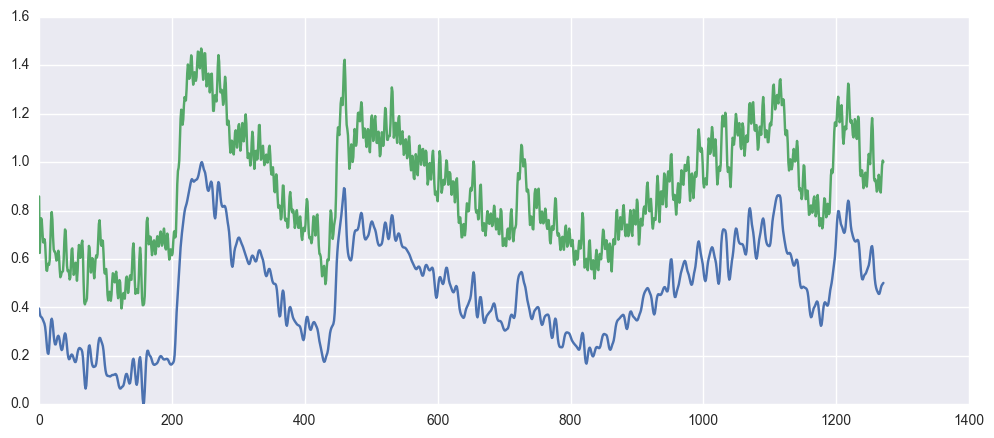

In [29]:
plt.figure(figsize=(12,5))
plt.plot(chirpAvgRgcGroupDeconvMean[:,0])
plt.plot(chirpAvgRgcGroupDeconvMean[:,0] + chirpAvgRgcGroupDeconvSd[:,0])


no smoothing


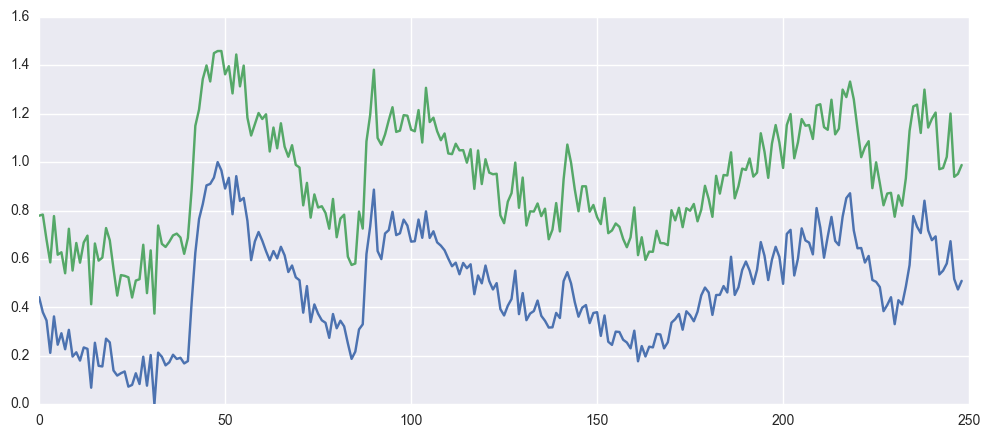

In [77]:
plt.figure(figsize=(12,5))
plt.plot(chirpAvgRgcGroupDeconvMean[:,0])
plt.plot(chirpAvgRgcGroupDeconvMean[:,0] + chirpAvgRgcGroupDeconvSd[:,0])
print('no smoothing')

smoothing: 50Hz


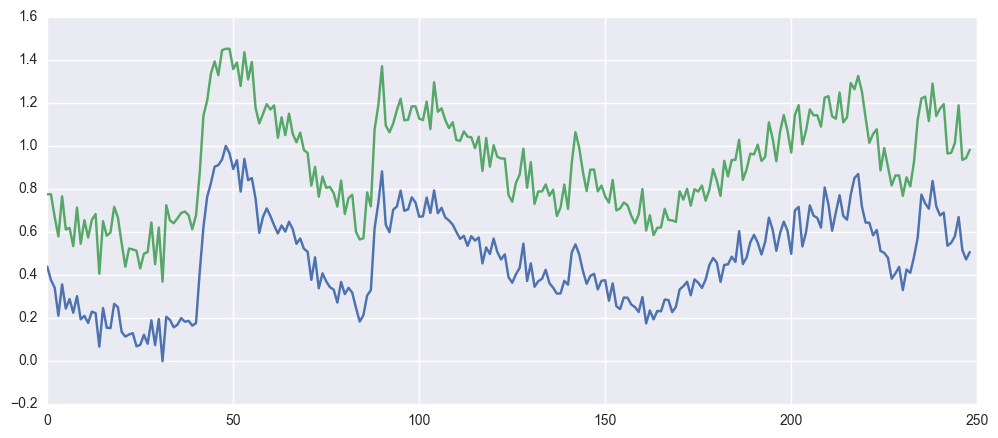

In [82]:
plt.figure(figsize=(12,5))
plt.plot(chirpAvgRgcGroupDeconvMean[:,0])
plt.plot(chirpAvgRgcGroupDeconvMean[:,0] + chirpAvgRgcGroupDeconvSd[:,0])
print('smoothing: 50Hz')

smoothing: 50Hz


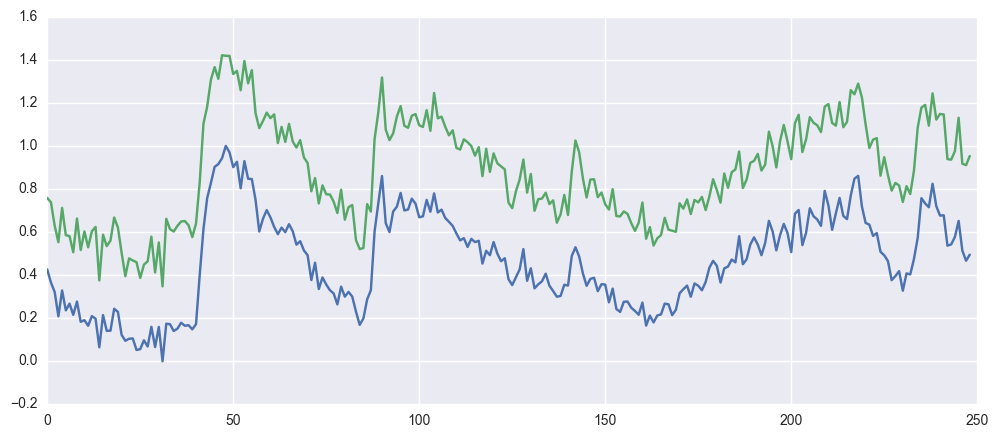

In [79]:
plt.figure(figsize=(12,5))
plt.plot(chirpAvgRgcGroupDeconvMean[:,0])
plt.plot(chirpAvgRgcGroupDeconvMean[:,0] + chirpAvgRgcGroupDeconvSd[:,0])
print('smoothing: 50Hz')

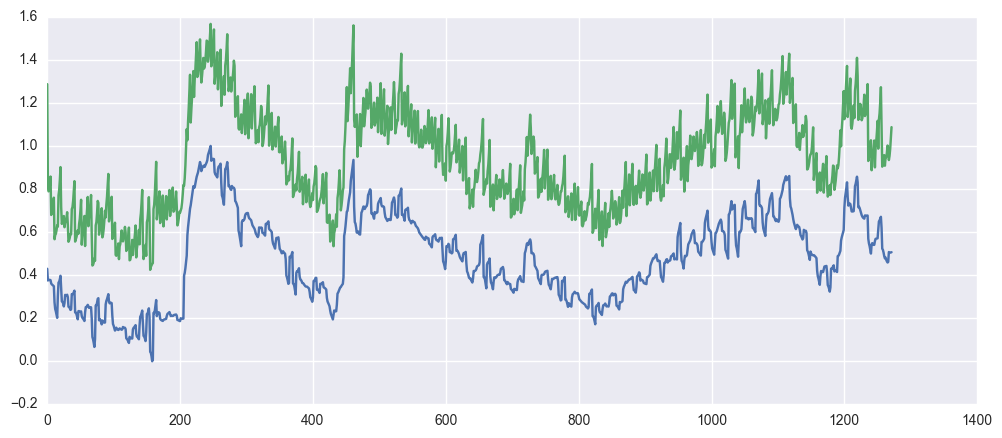

In [181]:
plt.figure(figsize=(12,5))
plt.plot(chirpAvgRgcGroupDeconvMean[:,0])
plt.plot(chirpAvgRgcGroupDeconvMean[:,0] + chirpAvgRgcGroupDeconvSd[:,0])
print('no smoothing')

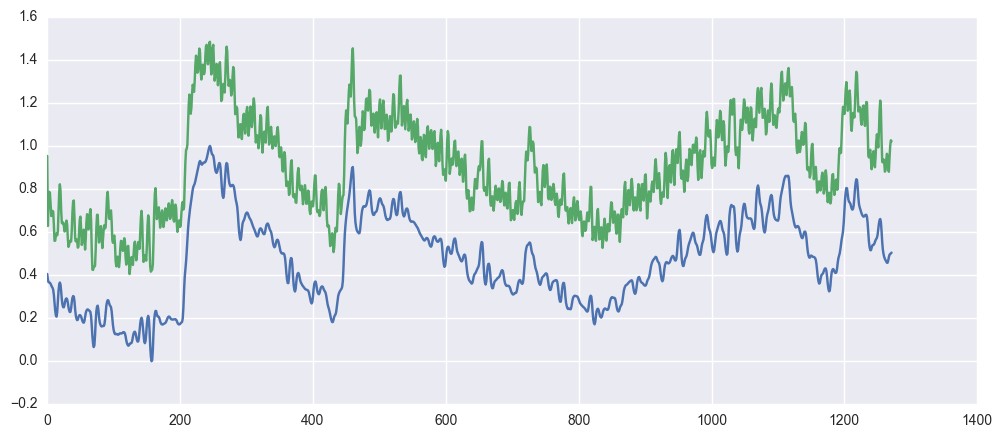

In [44]:
plt.figure(figsize=(12,5))
plt.plot(chirpAvgRgcGroupDeconvMean[:,0])
plt.plot(chirpAvgRgcGroupDeconvMean[:,0] + chirpAvgRgcGroupDeconvSd[:,0])
print('smoothing: 0.2')

smoothing: 0.3


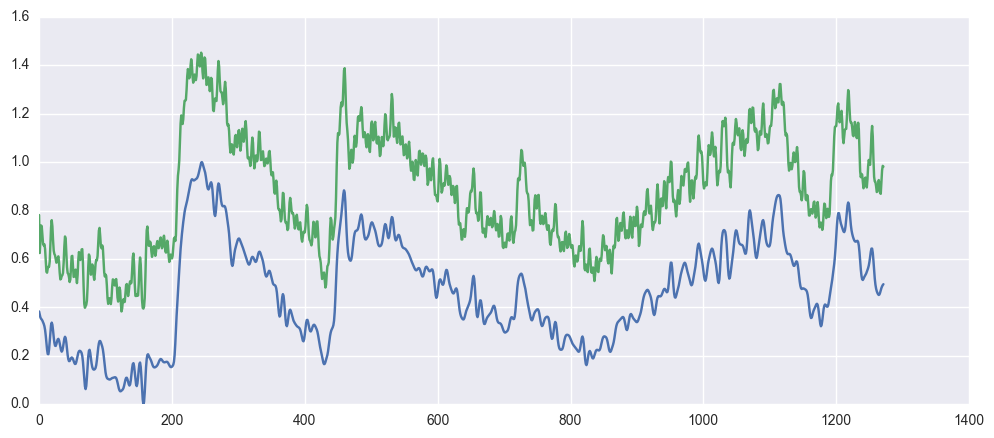

In [47]:
plt.figure(figsize=(12,5))
plt.plot(chirpAvgRgcGroupDeconvMean[:,0])
plt.plot(chirpAvgRgcGroupDeconvMean[:,0] + chirpAvgRgcGroupDeconvSd[:,0])
print('smoothing: 0.3')

smoothing: 0.4


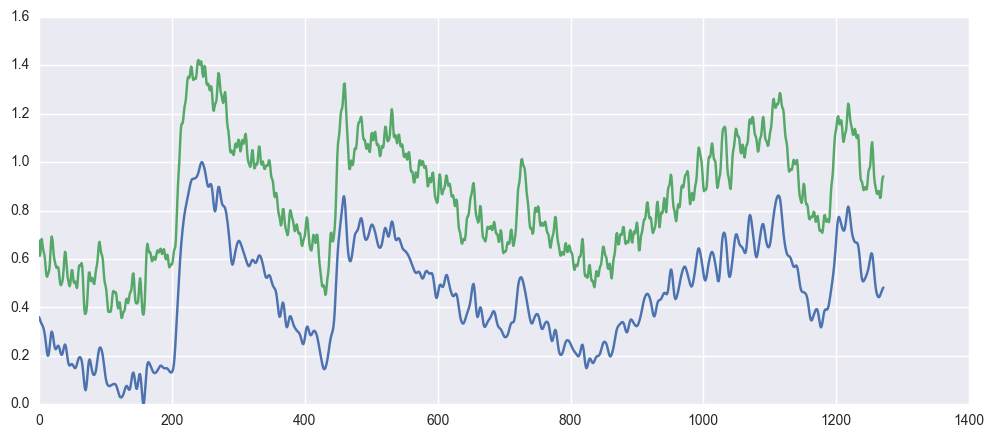

In [51]:
plt.figure(figsize=(12,5))
plt.plot(chirpAvgRgcGroupDeconvMean[:,0])
plt.plot(chirpAvgRgcGroupDeconvMean[:,0] + chirpAvgRgcGroupDeconvSd[:,0])
print('smoothing: 0.4')

smoothing: 0.5


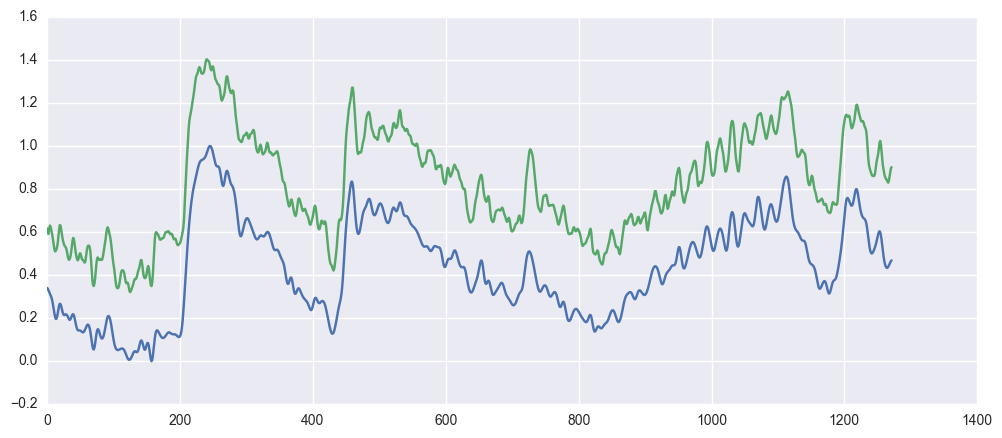

In [54]:
plt.figure(figsize=(12,5))
plt.plot(chirpAvgRgcGroupDeconvMean[:,0])
plt.plot(chirpAvgRgcGroupDeconvMean[:,0] + chirpAvgRgcGroupDeconvSd[:,0])
print('smoothing: 0.5')

In [161]:
i=5003
traces = chirpAvgRgc[:, i]
traces = pop.normalize(traces, mode='r') # Normalize 
d, traceSm = pop.deconv(traces, fps=p['chirpFps'], method=p['deconvMethod'], smooth=True, norm=True)
d = pop.normalize(d, mode='r') # Normalize 

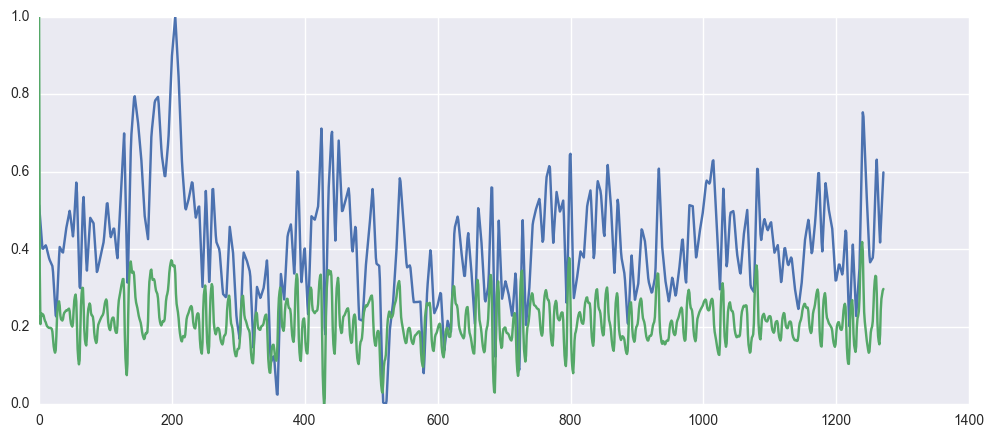

In [162]:
plt.figure(figsize=(12,5))
plt.plot(traces)
plt.plot(d)

## Check if groups are homogeneously DS or non-DS and make index of DS-groups

In [23]:
# Create group DS index
groupDsIdx = np.zeros((len(np.unique(groupIdxRgc)),1), dtype=int)
dsGroups = []

# Loop through each group
for i, val in enumerate(np.unique(groupIdxRgc)):
    print(val) # show group number
    print(cellDsiBool[groupIdxRgc == val]) # show cellDsiBool of all included cells
    
    # Call group DS if more than 50% of included cells are DS
    if sum(cellDsiBool[groupIdxRgc == val]) > len(cellDsiBool[groupIdxRgc == val])/2:
        print(' => >50% of group is DS')
        groupDsIdx[i] = 1
        dsGroups.append(val)
        
print('DS-Groups:', dsGroups)

1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 => >50% of group is DS
3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
4
[1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0
 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1
 1 1 0 1 1 1 1 1 0 1 

## Get soma size (area) of groups

In [24]:
# Hard code list of large-soma-groups according to Baden2016 (area > 136 mum^2)

if p['groupVClu'] == 'group':
    largeSomaGroup = [5, 8 ,19, 24]
elif p['groupVClu'] == 'clu':
    largeSomaGroup = [6, 7, 11, 12, 28, 34]
    

largeSomaGroup[:] = [x - 1 for x in largeSomaGroup] # Convert this into python indices

# Create index of whether or not group has large somas
somaSizeGroupIdx = np.zeros((nGroups, 1), dtype=int)
somaSizeGroupIdx[largeSomaGroup] = 1
print(somaSizeGroupIdx.T)

[[0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]]


## save

In [113]:
who

barAvg	 barAvgRgc	 barAvgRgcGroupDeconvMean	 barAvgRgcGroupDeconvSd	 barAvgRgcGroupMean	 barAvgRgcGroupMeanDeconv	 barAvgRgcGroupMed	 barAvgRgcGroupSd	 barDur	 
barN	 barQi	 barQiRgc	 barTime	 cellArea	 cellDsi	 cellDsiBool	 cellDsiPval	 chirpAvg	 
chirpAvgRgc	 chirpAvgRgcGroupDeconvMean	 chirpAvgRgcGroupDeconvSd	 chirpAvgRgcGroupMean	 chirpAvgRgcGroupMeanDeconv	 chirpAvgRgcGroupMed	 chirpAvgRgcGroupSd	 chirpDur	 chirpN	 
chirpQi	 chirpQiRgc	 chirpStimTime	 chirpTime	 d	 dsGroups	 dur	 gridspec	 groupDsIdx	 
groupIdx	 groupIdxRgc	 h5py	 i	 iGroup	 idx	 importlib	 interpolate	 largeSomaGroup	 
nGroups	 np	 ogb1	 os	 p	 plt	 pop	 print_function	 rcParams	 
rgcRange	 sio	 sns	 somaSizeGroupIdx	 start	 sys	 tPoints	 time	 trace	 
traceSm	 traces	 val	 warnings	 


In [149]:
# Test print
print('Saving to:', p['saveDir']+ p['saveFid'])

Saving to: ../../data/2P/proc/BadenEtAl_RGCs_2016_ogb1_group_ogb1Kern_40Hz.mat


In [115]:
# Save .mat file
# If individual cells are needed, then just save the chirpAvgRgc and barAvgRgc and 
sio.savemat(p['saveDir'],
#              'chirpAvgRgc': chirpAvgRgc, # single cell medians
            {'chirpMean': chirpAvgRgcGroupMean,
             'chirpMed': chirpAvgRgcGroupMed,
             'chirpSd': chirpAvgRgcGroupSd,
             'chirpDeconvMean': chirpAvgRgcGroupDeconvMean, # mean(deconv(trace))
             'chirpDeconvSd': chirpAvgRgcGroupDeconvSd,
             'chirpMeanDeconv': chirpAvgRgcGroupMeanDeconv, # deconv(mean(trace))
             'chirpTime': chirpTime,
             'chirpN': chirpN,
#              'chirpQi': chirpQi,
#              'barAvgRgc': barAvgRgc, # single cell medians
             'barMean': barAvgRgcGroupMean,
             'barMed': barAvgRgcGroupMed,             
             'barSd': barAvgRgcGroupSd,
             'barDeconvMean': barAvgRgcGroupDeconvMean, # mean(deconv(trace))
             'barDeconvSd': barAvgRgcGroupDeconvSd,
             'barMeanDeconv': barAvgRgcGroupMeanDeconv, # deconv(mean(trace))
             'barTime': barTime,
             'barN': barN,
#              'barQi': barQi,
#              'groupIdxRgc': groupIdxRgc,
             'dsIdx': groupDsIdx,
             'somaSizeIdx': somaSizeGroupIdx,
            })
print('Saved to:', p['saveDir'])

Saved to: ../../data/2P/proc/BadenEtAl_RGCs_2016_ogb1_groups_ogb1Kern_40Hz.mat


In [30]:
barAvgRgcGroupDeconvSd

array([[ 0.19582246,  0.19649462,  0.20133034, ...,  0.24813066,
         0.39421236,  0.53404867],
       [ 0.12323061,  0.1297757 ,  0.12660945, ...,  0.14137754,
         0.27109144,  0.36811002],
       [ 0.15185781,  0.15179091,  0.13729499, ...,  0.2011344 ,
         0.35421052,  0.47152571],
       ..., 
       [ 0.15836078,  0.17950695,  0.16329109, ...,  0.22844257,
         0.36179038,  0.4304775 ],
       [ 0.16258918,  0.18196162,  0.1659698 , ...,  0.2371364 ,
         0.37007395,  0.44535625],
       [ 0.16189148,  0.18062235,  0.16427039, ...,  0.23478886,
         0.36881807,  0.44310715]])

# TESTING PLAYGROUND

### Check if traces are normalized
- Positive

In [ ]:
# Randomly pick one trace to depict
traceSel = 4
rcParams['figure.figsize'] = 12,3
sns.tsplot(chirpAvg[:, traceSel], time = chirpTime)

# Deconvolve OGB-1 traces

## 1. deconv(mean())

In [19]:
chirpAvg.shape

(249, 11210)

In [20]:
chirpAvgRgc.shape

(249, 5024)

In [21]:
chirpAvgRgcGroupMean.shape

(249, 32)

In [22]:
#     deconvMean = np.zeros((snippets.shape[0], snippets.shape[2]))
#     for iRoi in range(snippets.shape[2]):
#         d, traceSm = deconv(snippets[:,:,iRoi], fps=ogb1SRate, method='ogb1Kern', smooth=False, norm=False)
#         deconvMean[:,iRoi] = np.mean(d, axis=1)

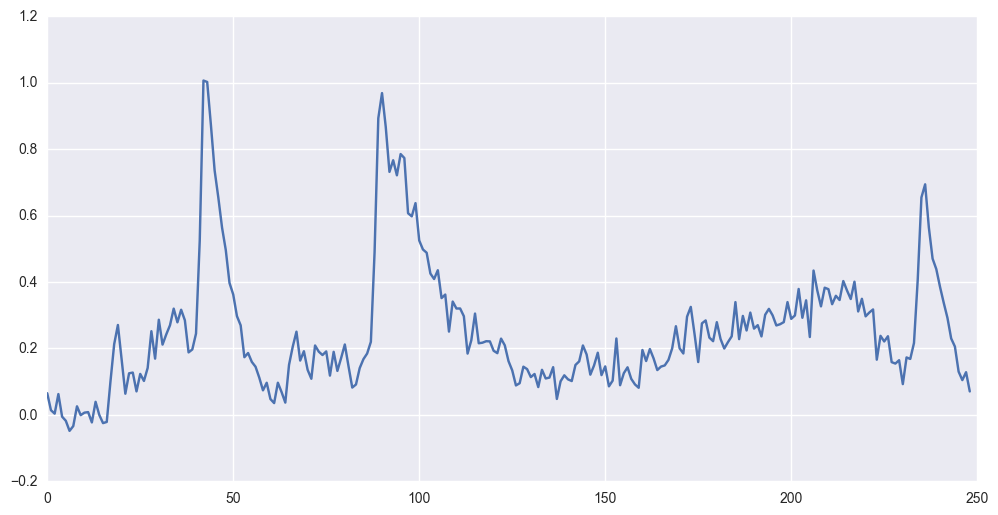

In [109]:
plt.figure(figsize=(12,6))
trace = chirpAvgRgcGroupMean[:,1]
plt.plot(trace)


### ogb1Kern 7.8 Hz

In [110]:
d, traceSm = pop.deconv(trace, fps=chirpFps, method='ogb1Kern', smooth=True, norm=False)
print(d.shape)

(249,)


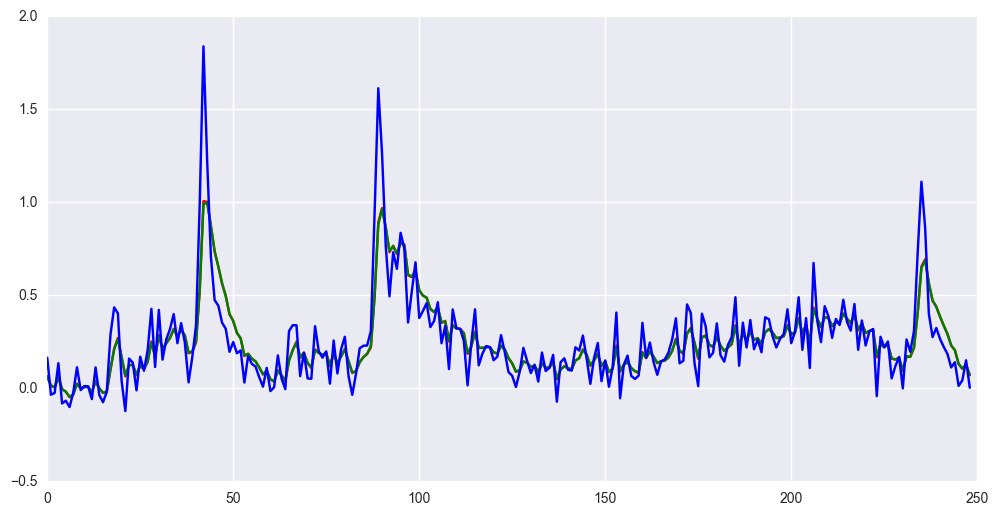

In [57]:
plt.figure(figsize=(12,6))
plt.plot(trace,'r')
plt.plot(traceSm,'g')
plt.plot(d,'b')

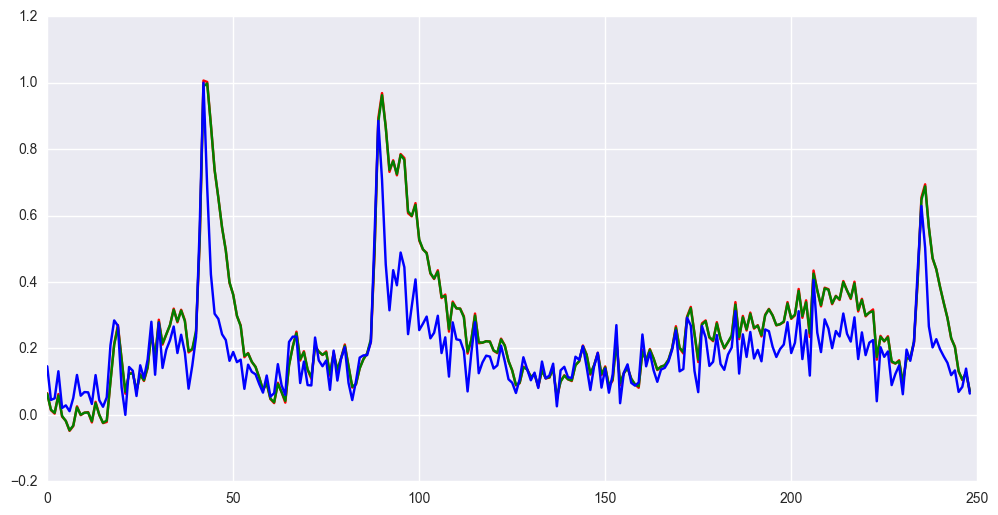

In [115]:
plt.figure(figsize=(12,6))
plt.plot(trace,'r')
plt.plot(traceSm,'g')
plt.plot(d,'b')

### ogb1Kern 40 Hz

In [121]:
traceR = pop.interpNewSRate(trace=trace, newSRate=40, duration=chirpDur, kind='cubic')
d, traceSm = pop.deconv(traceR, fps=40, method='ogb1Kern', smooth=True, norm=False)

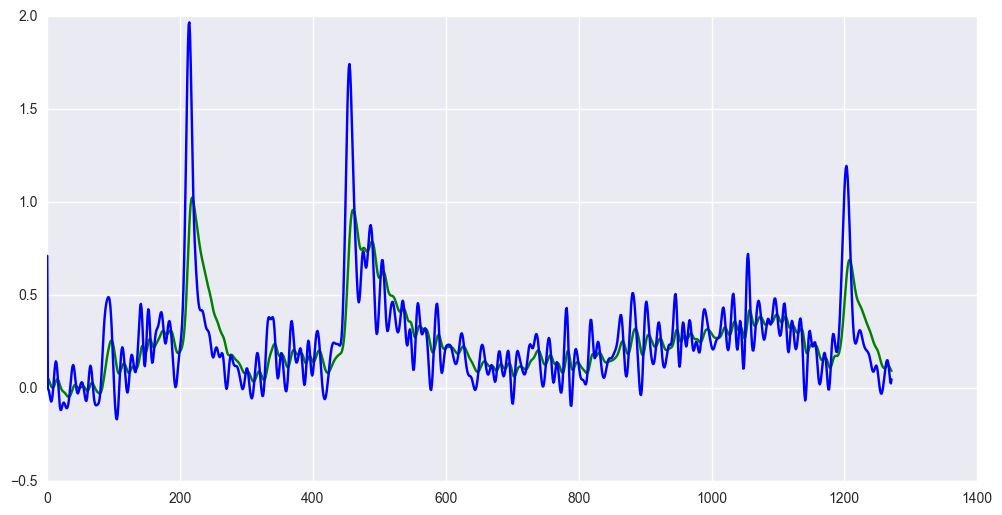

In [122]:
plt.figure(figsize=(12,6))
# plt.plot(trace,'r')
plt.plot(traceSm,'g')
plt.plot(d,'b')

### foopsi 7.8 Hz

In [116]:
# traceR = pop.interpNewSRate(trace=trace, newSRate=40, duration=chirpDur, kind='cubic')
d, traceSm = pop.deconv(trace, fps=chirpFps, method='foopsi', smooth=True, norm=False)

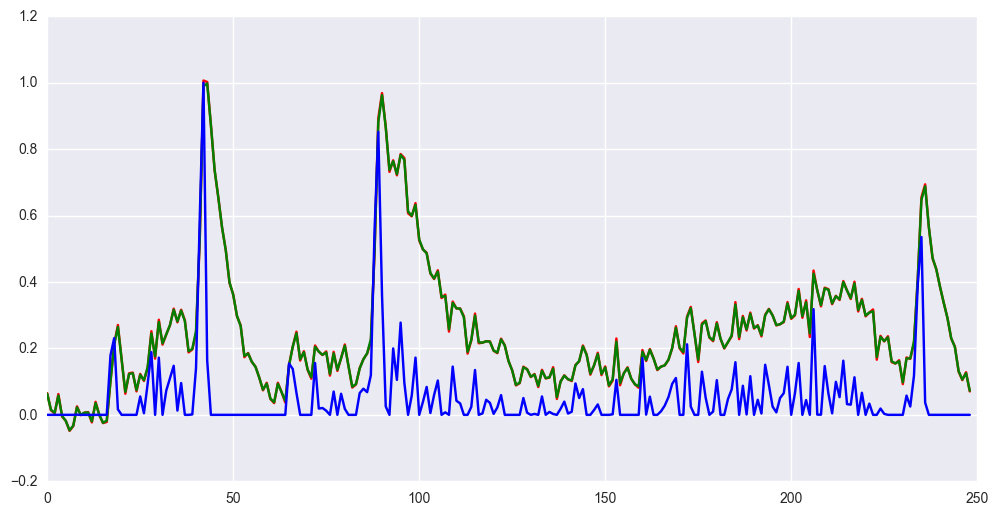

In [117]:
plt.figure(figsize=(12,6))
plt.plot(trace,'r')
plt.plot(traceSm,'g')
plt.plot(d,'b')

### foopsi 40 Hz

In [135]:
traceR = pop.interpNewSRate(trace=trace, newSRate=40, duration=chirpDur, kind='cubic')
print(traceR.shape)
d, traceSm = pop.deconv(traceR, fps=40, method='foopsi', smooth=True, norm=False)

(1272,)


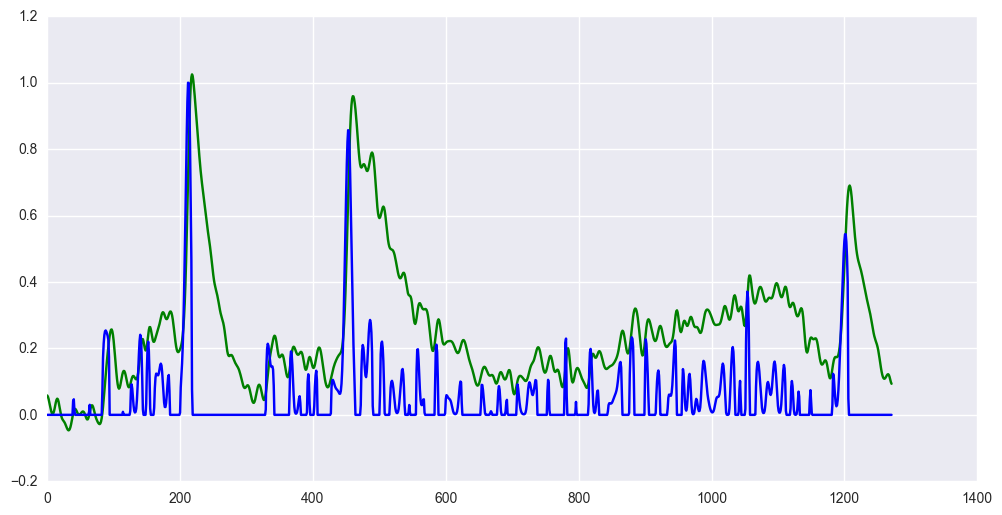

In [136]:
plt.figure(figsize=(12,6))
# plt.plot(trace,'r')
plt.plot(traceSm,'g')
plt.plot(d,'b')

## 2. mean(deconv())

### ogb1Kern

In [111]:
#     chirpAvgRgcGroupMean[:, idx] = np.mean(chirpAvgRgc[:, groupIdxRgc==iGroup], axis=1)
trace2 = chirpAvgRgc[:, groupIdxRgc==2]
print(trace.shape)
d2, traceSm2 = pop.deconv(trace2, fps=chirpFps, method='ogb1Kern', smooth=True, norm=False)
print(d.shape)

(249,)
(249,)


In [113]:
d -= np.min(d)
d /= np.max(d)

d2 -= np.min(np.mean(d2, axis=1))
d2 /= np.max(np.mean(d2, axis=1))

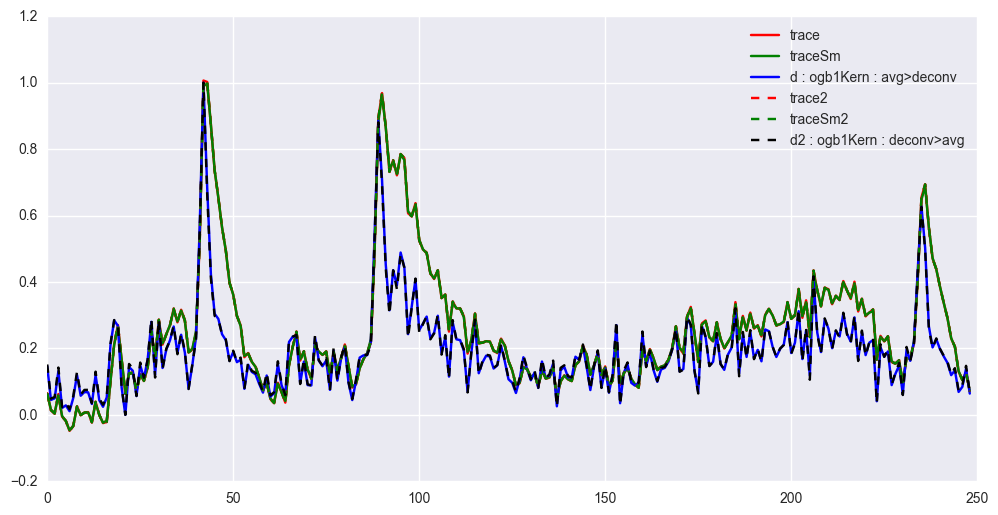

In [115]:
plt.figure(figsize=(12,6))
plt.plot(trace,'r', label='trace')
plt.plot(traceSm,'g', label='traceSm')
plt.plot(d,'b', label='d : ogb1Kern : avg>deconv')
plt.plot(np.mean(trace2, axis=1),'r--', label='trace2')
plt.plot(np.mean(traceSm2, axis=1),'g--', label='traceSm2')
plt.plot(np.mean(d2, axis=1),'k--', label='d2 : ogb1Kern : deconv>avg')
plt.legend()

### foopsi 7.8 Hz

In [118]:
trace2 = chirpAvgRgc[:, groupIdxRgc==2]
print(trace2.shape)
d2, traceSm2 = pop.deconv(trace2, fps=chirpFps, method='foopsi', smooth=True, norm=False)
print(d2.shape)

(249, 162)
(249, 162)


In [119]:
d2 -= np.min(np.mean(d2, axis=1))
d2 /= np.max(np.mean(d2, axis=1))

In [120]:
np.max(d2)

3.5440078186548254

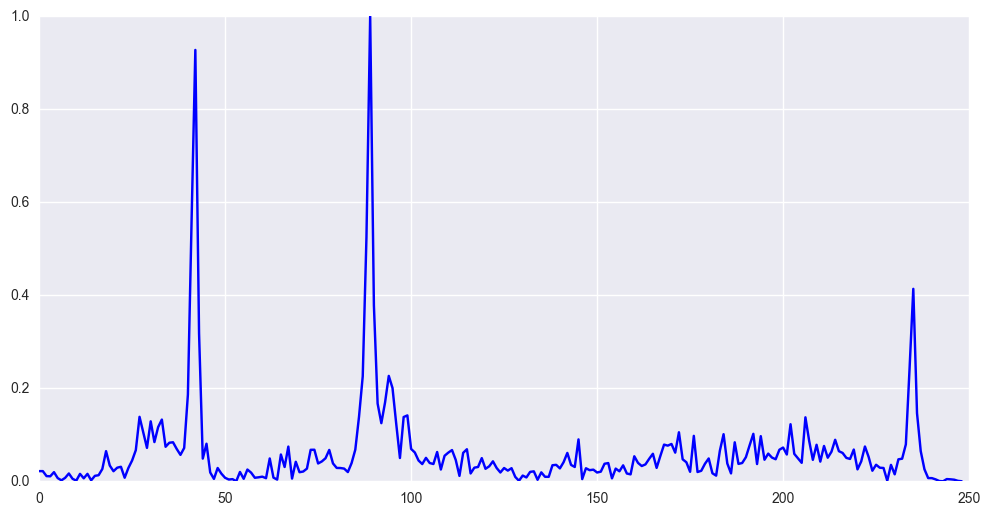

In [121]:
plt.figure(figsize=(12,6))
plt.plot(np.mean(d2, axis=1),'b-', label='d2')

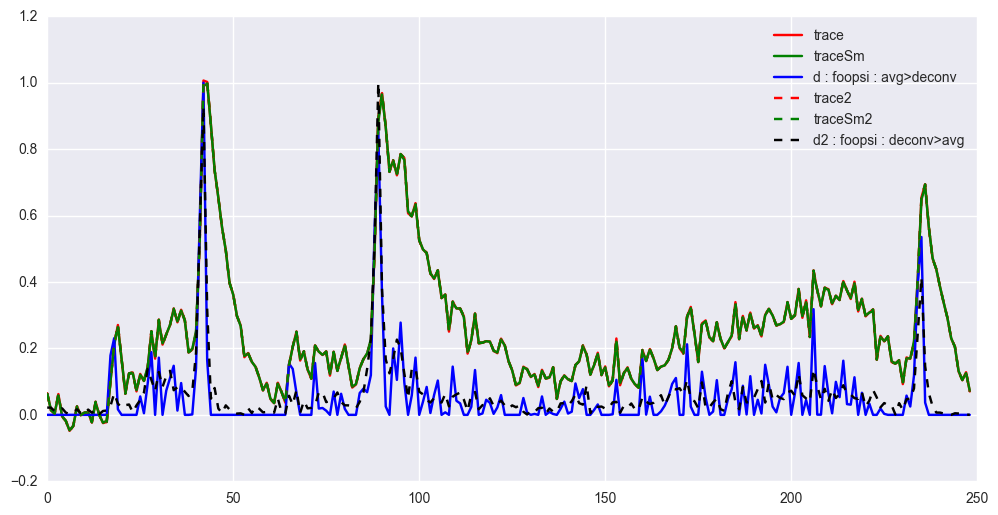

In [122]:
plt.figure(figsize=(12,6))
plt.plot(trace,'r', label='trace')
plt.plot(traceSm,'g', label='traceSm')
plt.plot(d,'b', label='d : foopsi : avg>deconv')
plt.plot(np.mean(trace2, axis=1),'r--', label='trace2')
plt.plot(np.mean(traceSm2, axis=1),'g--', label='traceSm2')
plt.plot(np.mean(d2, axis=1),'k--', label='d2 : foopsi : deconv>avg')
plt.legend()

### foopsi 40 Hz

In [145]:
%time
traceR2 = pop.interpNewSRate(trace=trace2, newSRate=40, duration=chirpDur, kind='cubic')
print(traceR2.shape)
d2, traceSm2 = pop.deconv(traceR2, fps=40, method='foopsi', smooth=True, norm=False)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
(1272, 162)


In [149]:
d2 -= np.min(np.mean(d2, axis=1))
d2 /= np.max(np.mean(d2, axis=1))

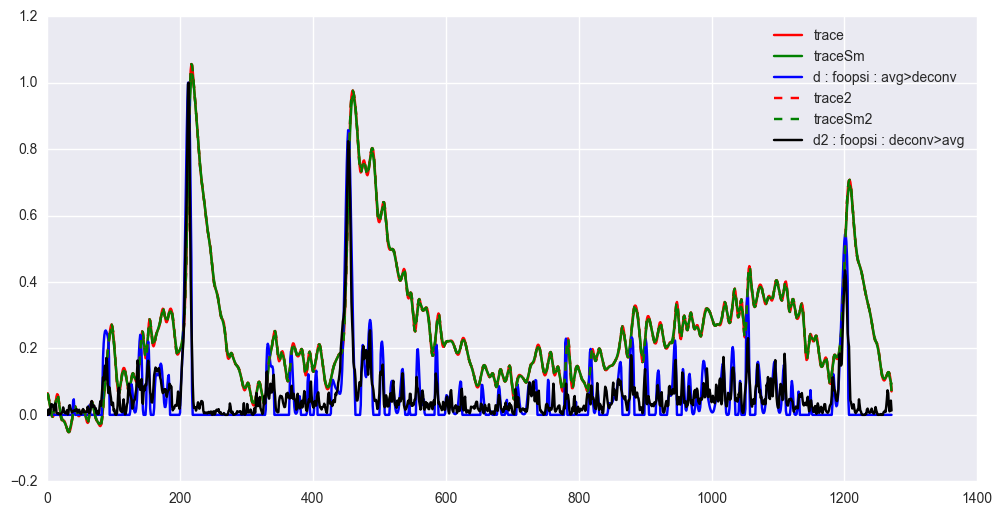

In [153]:
plt.figure(figsize=(12,6))
plt.plot(traceR,'r', label='trace')
plt.plot(traceSm,'g', label='traceSm')
plt.plot(d,'b', label='d : foopsi : avg>deconv')
plt.plot(np.mean(traceR2, axis=1),'r--', label='trace2')
plt.plot(np.mean(traceSm2, axis=1),'g--', label='traceSm2')
plt.plot(np.mean(d2, axis=1),'k-', label='d2 : foopsi : deconv>avg')
plt.legend()

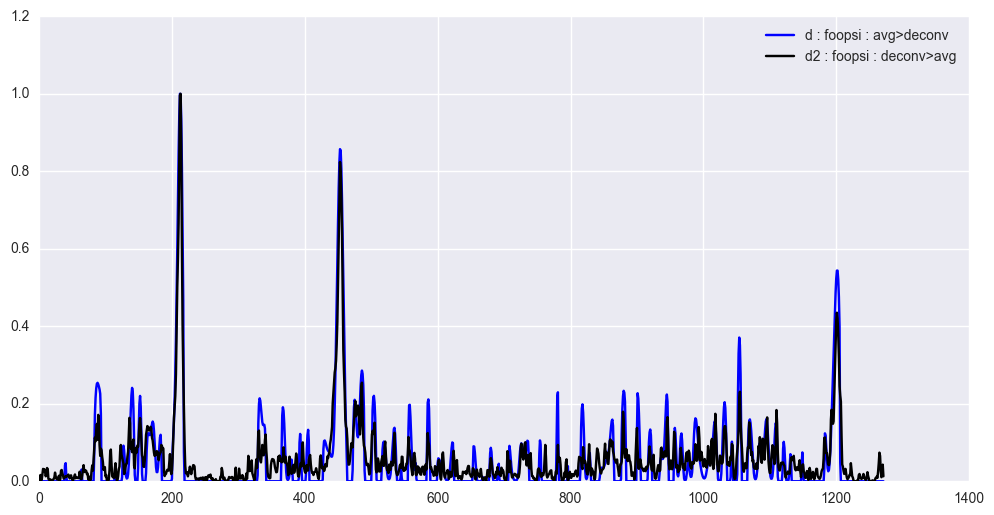

In [152]:
plt.figure(figsize=(12,6))
# plt.plot(traceR,'r', label='trace')
# plt.plot(traceSm,'g', label='traceSm')
plt.plot(d,'b', label='d : foopsi : avg>deconv')
# plt.plot(np.mean(traceR2, axis=1),'r--', label='trace2')
# plt.plot(np.mean(traceSm2, axis=1),'g--', label='traceSm2')
plt.plot(np.mean(d2, axis=1),'k-', label='d2 : foopsi : deconv>avg')
plt.legend()

## Test multiprocessing

In [149]:
!nproc

/bin/sh: nproc: command not found


In [23]:
import multiprocessing as mp
nProc = mp.cpu_count()
pool = mp.Pool(processes=nProc)

In [151]:
%%time
for i in range(1000):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27